In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

import create_parallel_corridors
from shared_utils import geography_utils

DATA_PATH = create_parallel_corridors.DATA_PATH

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [6]:
# See how transit_routes.parquet was created
routes_assembled = gpd.read_parquet("../traffic_ops/data/routes_assembled.parquet")

transit_routes = create_parallel_corridors.process_transit_routes(routes_assembled)

In [ ]:
'''
transit_routes = gpd.read_parquet(f"{DATA_PATH}transit_routes.parquet")

len(transit_routes)
transit_routes.head(2)


routes_assembled = gpd.read_parquet("../traffic_ops/data/routes_assembled.parquet")
len(routes_assembled)
routes_assembled.head(2)
'''

In [7]:
gdf = gpd.read_parquet(f"{DATA_PATH}parallel_or_intersecting.parquet")
highways= gpd.read_parquet(f"{DATA_PATH}highways.parquet")

In [8]:
gdf = gdf[gdf.itp_id==182].reset_index(drop=True)
transit_routes = transit_routes[transit_routes.itp_id==182].reset_index(drop=True)

In [9]:
# Take a look at these routes that seem to get truncated with City of LA boundary

keep_routes = ["806", "40", "105", "108", "110", "111"]

for i in keep_routes:
    transit_routes['keep'] = transit_routes.route_id.apply(lambda x: 
                                                           1 if any(i in x for i in keep_routes) 
                                                           else 0)
    gdf['keep'] = gdf.route_id.apply(lambda x: 
                                     1 if any(i in x for i in keep_routes)
                                     else 0
                                    )

In [10]:
gdf = gdf[gdf.keep==1].reset_index(drop=True)
transit_routes = transit_routes[transit_routes.keep==1].reset_index(drop=True)

## Original Transit Routes

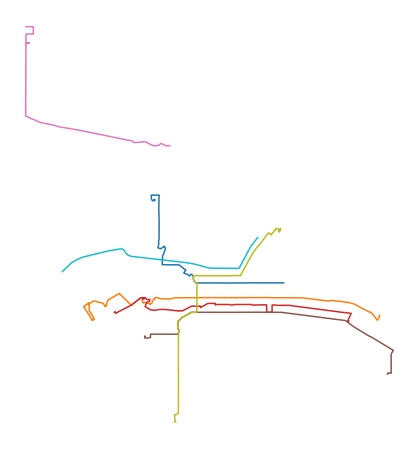

In [11]:
fig, ax = plt.subplots(figsize  = (12, 8))
transit_routes.plot(column="route_id", ax = ax)
ax.set_axis_off()
display(fig)
plt.close()

In [12]:
transit_routes.route_id.nunique()

7

## Processed Transit Routes

Something is happening during the processing where the original geometry is getting lost. It looks like it's getting truncated with City of LA boundaries.

Debug: maybe in the `gpd.overlay`, the highway `geometry` or highway `dissolve` by `RouteType` is affecting transit route geometry.

In [ ]:
fig, ax = plt.subplots(figsize  = (12, 8))
gdf.plot(column="route_id", ax = ax)
ax.set_axis_off()
display(fig)
plt.close()

In [ ]:
gdf2 = gpd.overlay(transit_routes, highways, how = "intersection")  

gdf2 = gdf2.assign(
        pct_route = (gdf2.geometry.length / gdf2.route_length).round(3),
        pct_highway = (gdf2.geometry.length / gdf2.highway_length).round(3),
    )


gdf2 = gdf2.assign(
    pct_highway = gdf2.apply(lambda x: 1 if x.pct_highway > 1 
                            else x.pct_highway, axis=1),
)
    

In [ ]:
fig, ax = plt.subplots(figsize  = (12, 8))
gdf2.plot(column="route_id", ax = ax)
ax.set_axis_off()
display(fig)
plt.close()

Interestingly, `create_parallel_corridors` doesn't indicate where the `overlay` geometry is reverted back to the original.

But, the map doesn't show `overlay` geometry either, which is super tiny, it shows a larger aggregation. Where did this come from?

Reconstruct file from `transit_routes` to `gdf` again, do the `gpd.overlay`, do a merge to bring back the correct geometry, and add those changes to `create_parallel_corridors`.

In [ ]:
gdf3 = pd.merge(transit_routes[["itp_id", "shape_id", "geometry"]],
        gdf2.drop(columns = "geometry"),
         on = ["itp_id", "shape_id"],
         how = "outer",
        # Allow 1:m merge because the same transit route can overlap with various highways
         validate = "1:m",
)

In [ ]:
fig, ax = plt.subplots(figsize  = (12, 8))
gdf3.plot(column="route_id", ax = ax)
ax.set_axis_off()
display(fig)
plt.close()

## Try to create new files again

In [ ]:
from shared_utils import geography_utils

routes_assembled = gpd.read_parquet("../traffic_ops/data/routes_assembled.parquet")

In [ ]:
create_parallel_corridors.make_analysis_data(
    hwy_buffer_feet= geography_utils.FEET_PER_MI, 
    alternate_df = routes_assembled,
    pct_route_threshold = 0.3,
    pct_highway_threshold = 0.1,
    DATA_PATH = create_parallel_corridors.DATA_PATH, 
    FILE_NAME = "parallel_or_intersecting2"
)

In [2]:
fixed = gpd.read_parquet(f"{DATA_PATH}parallel_or_intersecting2.parquet")

In [3]:
fixed = fixed[fixed.itp_id==182]

keep_routes = ["806", "40", "105", "108", "110", "111"]

fixed['keep'] = fixed.route_id.apply(lambda x: 
                                 1 if any(i in x for i in keep_routes)
                                 else 0
                                )

fixed = fixed[fixed.keep==1].reset_index(drop=True)

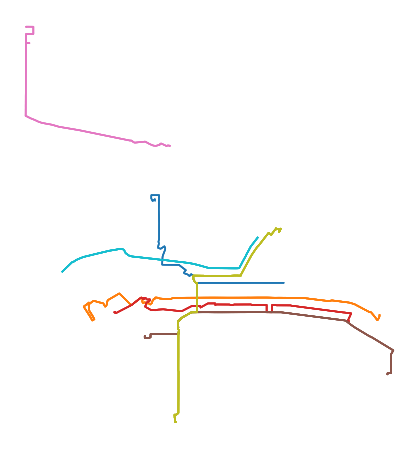

In [4]:
fig, ax = plt.subplots(figsize  = (12, 8))
fixed.plot(column="route_id", ax = ax)
ax.set_axis_off()
display(fig)
plt.close()

In [5]:
fixed.route_id.nunique()

7